# <center>互评作业二：网页浏览行为关联规则挖掘<center>

# <center>1120193405  许阳霄  07111908班<center> 

github地址为：https://github.com/Xuyangxiao0604/BIT-Datamining-homework2/upload/main

## 一、数据预处理

（1）加载数据集，探索数据集基本形状

In [3]:
import numpy as np
import pandas as pd

# 训练集和测试集数据路径
data_path = 'anonymous-msweb.data'
test_path = 'anonymous-msweb.test'

data = open(data_path).readlines()
test = open(test_path).readlines()

# anonymous-msweb.data数据集的前几行
print("anonymous-msweb.data数据集的前几行：\n", data[:10])
# anonymous-msweb.test数据集的前几行
print("anonymous-msweb.test数据集的前几行：\n", test[:10])

anonymous-msweb.data数据集的前几行：
 ['I,4,"www.microsoft.com","created by getlog.pl"\n', 'T,1,"VRoot",0,0,"VRoot"\n', 'N,0,"0"\n', 'N,1,"1"\n', 'T,2,"Hide1",0,0,"Hide"\n', 'N,0,"0"\n', 'N,1,"1"\n', 'A,1287,1,"International AutoRoute","/autoroute"\n', 'A,1288,1,"library","/library"\n', 'A,1289,1,"Master Chef Product Information","/masterchef"\n']
anonymous-msweb.test数据集的前几行：
 ['I,4,"www.microsoft.com","created by getlog.pl"\n', 'T,1,"VRoot",0,0,"VRoot"\n', 'N,0,"0"\n', 'N,1,"1"\n', 'T,2,"Hide1",0,0,"Hide"\n', 'N,0,"0"\n', 'N,1,"1"\n', 'A,1277,1,"NetShow for PowerPoint","/stream"\n', 'A,1253,1,"MS Word Development","/worddev"\n', 'A,1109,1,"TechNet (World Wide Web Edition)","/technet"\n']


（2）统计data信息和test信息

In [4]:
A_count = 0  # 记录属性数
C_count = 0  # 记录case数
V_count = 0  # 记录投票数
Attributes = {}  # 属性与编号映射字典
Cases = []  # 案例号
Votes = []  # 各案例投票

# 统计data数据
for i in range(len(data)):
    item = data[i].split(',')
    if item[0] == 'A':
        A_count += 1
        Attributes[int(item[1])] = item[3]
    if item[0] == 'C':
        C_count += 1
        Cases.append(int(item[1].split('"')[1]))
        vote = []
        while (i < len(data) - 1):
            i += 1
            if data[i][0] != 'V':
                break
            V_count += 1
            vote.append(int(data[i].split(',')[1]))
        Votes.append(vote)

# 统计test数据
for i in range(len(test)):
    item = test[i].split(',')
    if item[0] == 'A':
        A_count += 1
        Attributes[int(item[1])] = item[3]
    if item[0] == 'C':
        C_count += 1
        Cases.append(int(item[1].split('"')[1]))
        vote = []
        while (i < len(test) - 1):
            i += 1
            if test[i][0] != 'V':
                break
            V_count += 1
            vote.append(int(test[i].split(',')[1]))
        Votes.append(vote)

    
# 打印基本信息
print('数据集属性A数量:', A_count)
print('数据集属性C数量:', C_count)
print('数据集属性V数量:', V_count)

数据集属性A数量: 588
数据集属性C数量: 37711
数据集属性V数量: 113845


（3）属性去重

In [5]:
print("去重之后：")
# 统计属性种数
arr_unique = set()
for attributes in Attributes: # type: ignore
    arr_unique.add(attributes)
print('所有的属性有 %d 种' % len(arr_unique))

# 统计属性种数
case_unique = set()
for case in Cases:
    case_unique.add(case)
print('所有的投票用户有 %d 个' % len(case_unique))

# 统计投票属性种数
vote_unique = set()
for Vote in Votes:
    for item in Vote:
        vote_unique.add(item)
print('所有被投票的属性有 %d 种' % len(vote_unique))

去重之后：
所有的属性有 294 种
所有的投票用户有 32711 个
所有被投票的属性有 286 种


## 二、数据探索性分析

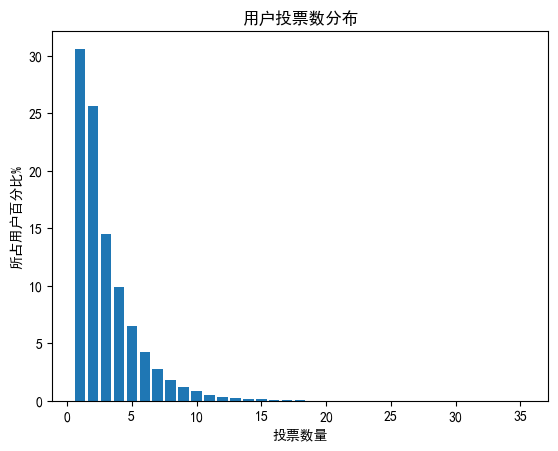

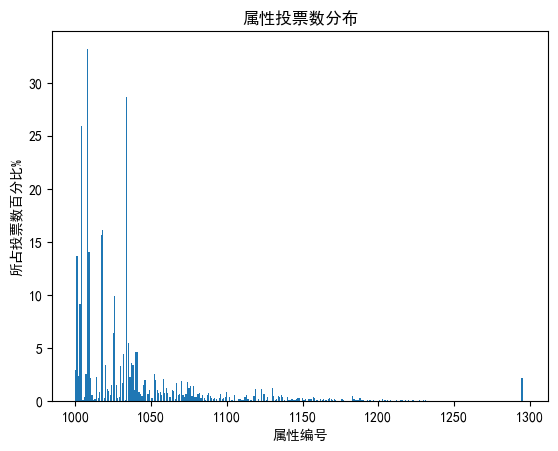

In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict

# 数据可视化
votes_every_attr = defaultdict(int)  # 每个属性获得的投票数
votes_every_case = []  # 每个用户的投票数
# 遍历数据项
for item in Votes:
    votes_every_case.append(len(item))
    for attr in item:
        votes_every_attr[attr] += 1
# 画出不同投票数的用户的分布
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

lens, counts = np.unique(np.array(votes_every_case), return_counts=True)
plt.bar(lens, counts / len(Votes) * 100)
plt.title('用户投票数分布')
plt.xlabel('投票数量')
plt.ylabel('所占用户百分比%')
# 画出不同属性的投票数分布
plt.figure(2)
attrs = list(votes_every_attr.keys())
vote_counts = list(votes_every_attr.values())
plt.bar(attrs, np.array(vote_counts) / len(Votes) * 100)
plt.title('属性投票数分布')
plt.xlabel('属性编号')
plt.ylabel('所占投票数百分比%')
plt.show(block=True)

可以看到，用户的投票数量依次递减，对编号1000到1050之间的属性投票占比最大。

## 三、关联规则挖掘

使用Apriori算法根据用户浏览记录计算频繁项集。

In [8]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()  
df_tf = te.fit_transform(Votes)  
df = pd.DataFrame(df_tf, columns = te.columns_) # type: ignore

# 计算频繁项集
frequent_itemsets = apriori(df, min_support=0.02, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)
print("\n频繁项集如下：")
print(frequent_itemsets)  


频繁项集如下：
     support                  itemsets
6   0.331760                    (1008)
17  0.287025                    (1034)
4   0.259526                    (1004)
49  0.161544              (1008, 1034)
11  0.161279                    (1018)
..       ...                       ...
69  0.021214        (1018, 1035, 1003)
26  0.020525                    (1058)
67  0.020418        (1008, 1001, 1018)
25  0.020312                    (1053)
78  0.020100  (1008, 1009, 1018, 1035)

[79 rows x 2 columns]


## 四、结果评估 

计算关联规则的支持度、置信度和提升度，得出强关联规则。置信度阈值设置为0.8。

In [9]:
# 计算关联规则
association_rule = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)  # 关联规则发掘，置信度阈值为0.8 
print("\n关联规则如下：")
print(association_rule)


关联规则如下：
          antecedents consequents  antecedent support  consequent support  \
0              (1035)      (1018)            0.054281            0.161279   
1              (1037)      (1009)            0.035719            0.140410   
2        (1009, 1035)      (1018)            0.032696            0.161279   
3              (1038)      (1026)            0.034446            0.099096   
4        (1008, 1035)      (1018)            0.027127            0.161279   
5        (1001, 1035)      (1018)            0.029275            0.161279   
6        (1008, 1035)      (1009)            0.027127            0.140410   
7        (1035, 1003)      (1018)            0.024104            0.161279   
8  (1008, 1009, 1035)      (1018)            0.022354            0.161279   
9  (1008, 1018, 1035)      (1009)            0.024396            0.140410   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.045584    0.839766  5.206905  0.036829    5.234334       0.854321

## 五、结果分析与应用 

由上一小节计算出的关联规则，可以根据支持度、置信度、提升度由高到低依次调节模块的前后关系，把前后支持度更高的组合放置在一起，这样可以使用户有更好的体验。